# Binary Classification of Insurance Cross Selling

Playground Series - Season 4, Episode 7

(https://www.kaggle.com/competitions/playground-series-s4e7/)

![image](./data/picture.png)

__Overview__
Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

__Your Goal:__ The objective of this competition is to predict which customers respond positively to an automobile insurance offer.

__Dataset Description__
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Health Insurance Cross Sell Prediction Data dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

__Files__

- train.csv - the training dataset; Exited is the binary target
- test.csv - the test dataset; your objective is to predict the probability of Exited
- sample_submission.csv - a sample submission file in the correct format

__Models__
- K-Nearest Neighboor Model 
- Gaussian Naive Bayes Model 
- Logistic Regressor 
- Support Vector Classification Model 
- Decision Tree Model 
- Random Forest Model 
- Linear Discriminant Analysis Model 
- Gradient Boosting Classifier Model 
- Neural Network CLassifier Model 
- X Gradient Boost Classifier
- Cat Boosting Classifier

In [1]:
%pip install -r requirements.txt --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 20.9 MB/s eta 0:00:0000:0100:01
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import all necessary libraries

import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import datetime as dt
import warnings as wn
import matplotlib.pyplot as plt

from catboost import Pool
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

In [2]:
# Ignore all warnings
wn.filterwarnings('ignore')

In [3]:
# Set all variables paths 

_plots = './plots/'
_tested = './tested/'
_test = './data/test.csv'
_train = './data/train.csv'
_info = './model/model.docx'
_model = './model/model.pkl'
_submission = './data/sample_submission.csv'

In [4]:
# Simplify the process of integrating large CSV

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file, **kwargs):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, **kwargs)
    df = reduce_mem_usage(df)
    return df

In [5]:
# Read the training and testing datasets and preprocess
train = import_data(_train, index_col = "id", engine="pyarrow")

Memory usage of dataframe is 1053.30 MB
Memory usage after optimization is: 274.30 MB
Decreased by 74.0%


In [6]:
# Set the datatype of each column for memory eficiency

train["Policy_Sales_Channel"] = train["Policy_Sales_Channel"].astype(np.int16)
train["Region_Code"] = train["Region_Code"].astype(np.int8)

In [7]:
# Display the first n rows of training
train.head(n=10)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35,0,1-2 Year,Yes,65101.0,124,187,0
1,Male,43,1,28,0,> 2 Years,Yes,58911.0,26,288,1
2,Female,25,1,14,1,< 1 Year,No,38043.0,152,254,0
3,Female,35,1,1,0,1-2 Year,Yes,2630.0,156,76,0
4,Female,36,1,15,1,1-2 Year,No,31951.0,152,294,0
5,Female,31,1,47,1,< 1 Year,No,28150.0,152,197,0
6,Male,23,1,45,1,< 1 Year,No,27128.0,152,190,0
7,Female,47,1,8,0,1-2 Year,Yes,40659.0,26,262,1
8,Female,26,1,28,1,< 1 Year,No,31639.0,152,36,0


In [31]:
# Describe the data
train.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046136e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.640609e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [45]:
# Display more info about the data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Gender                category
 1   Age                   int8    
 2   Driving_License       int8    
 3   Region_Code           int8    
 4   Previously_Insured    int8    
 5   Vehicle_Age           category
 6   Vehicle_Damage        category
 7   Annual_Premium        float32 
 8   Policy_Sales_Channel  int16   
 9   Vintage               int16   
 10  Response              int8    
dtypes: category(3), float32(1), int16(2), int8(5)
memory usage: 263.3 MB


In [13]:
# Verify if there are null values
train.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [7]:
# Check for dublicates
print(train.duplicated().sum())
train.drop_duplicates()

0


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35,0,1-2 Year,Yes,65101.0,124,187,0
1,Male,43,1,28,0,> 2 Years,Yes,58911.0,26,288,1
2,Female,25,1,14,1,< 1 Year,No,38043.0,152,254,0
3,Female,35,1,1,0,1-2 Year,Yes,2630.0,156,76,0
4,Female,36,1,15,1,1-2 Year,No,31951.0,152,294,0
...,...,...,...,...,...,...,...,...,...,...,...
11504793,Male,48,1,6,0,1-2 Year,Yes,27412.0,26,218,0
11504794,Female,26,1,36,0,< 1 Year,Yes,29509.0,152,115,1
11504795,Female,29,1,32,1,< 1 Year,No,2630.0,152,189,0


In [8]:
# Set the columns names
names = train.columns
names

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [7]:
# Check for outliers

def remove_outliers(df):

    outliers_columns = []
    total_rows = len(df)
    
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        outlier_count = outliers.sum()
        outlier_percentage = (outlier_count / total_rows) * 100
        
        if outlier_percentage >= 20:
            outliers_columns.append(column)
            print(f"Outliers detected in column '{column}': {outlier_percentage:.2f}% of total rows.")
            
            df = df[~outliers]
            print(f"Removed {outlier_count} outliers from column '{column}'.")
    
    if not outliers_columns:
        print("No columns with outliers exceeding 20% detected.")

    return df
    
train = remove_outliers(train)

Outliers detected in column 'Annual_Premium': 20.66% of total rows.
Removed 2377273 outliers from column 'Annual_Premium'.


In [8]:
# One Hot Encode the training data
train = pd.get_dummies(train, columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage'])

In [9]:
# Rename columns encoded
train.rename(columns = {'Vehicle_Age_< 1 Year': 'Vehicle Age Less than 1 yr',
                           'Vehicle_Age_1-2 Year': 'Vehicle Age between 1 and 2 yrs',
                           'Vehicle_Age_> 2 Years': 'Vehicle Age greater than 2 yrs'
                          }, inplace = True)

In [10]:
# Set the dataframes from training data
response = train.pop('Response')
train.insert(len(train.columns), 'Response', response)
y_data = pd.DataFrame(train['Response'])
X_data = pd.DataFrame(train.iloc[:,:-1])

In [30]:
# Reshape for unbalanced data
smoteenn = SMOTEENN()
X_data, y_data = smoteenn.fit_resample(X_data, y_data)

In [11]:
# Split The Training And Testing Data

rows = train.shape[0]
cols = train.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [19]:
# Fill the null values with zero

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [74]:
# Newer input and output data
train

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Vehicle Age between 1 and 2 yrs,Vehicle Age Less than 1 yr,Vehicle Age greater than 2 yrs,Vehicle_Damage_No,Vehicle_Damage_Yes,Response
id,,,,,,,,,,,,,,,
1,43,1,28,0,58911.0,26,288,0,1,0,0,1,0,1,1
2,25,1,14,1,38043.0,152,254,1,0,0,1,0,1,0,0
4,36,1,15,1,31951.0,152,294,1,0,1,0,0,1,0,0
5,31,1,47,1,28150.0,152,197,1,0,0,1,0,1,0,0
6,23,1,45,1,27128.0,152,190,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504792,34,1,28,1,29974.0,154,201,0,1,1,0,0,1,0,0
11504793,48,1,6,0,27412.0,26,218,0,1,1,0,0,0,1,0
11504794,26,1,36,0,29509.0,152,115,1,0,0,1,0,0,1,1


# Plotting Training Data

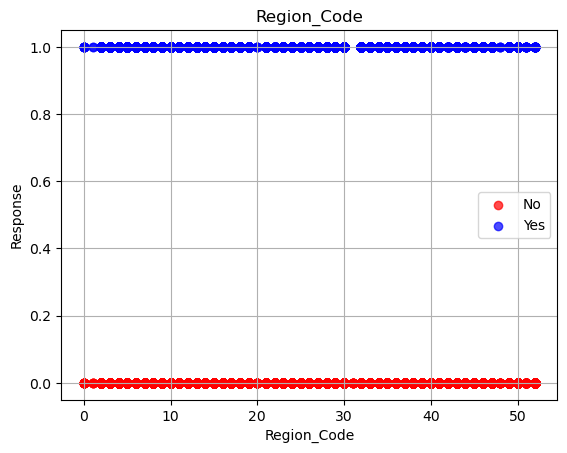

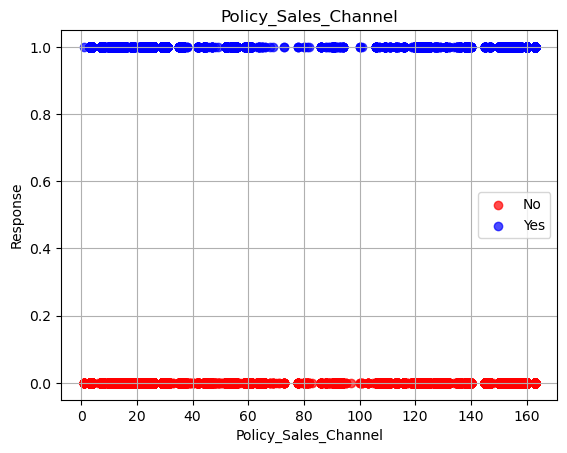

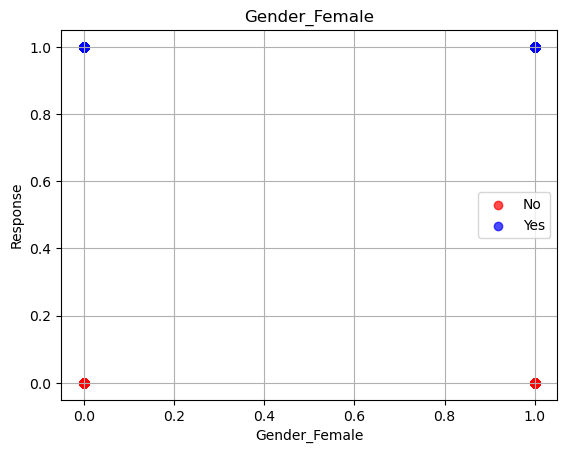

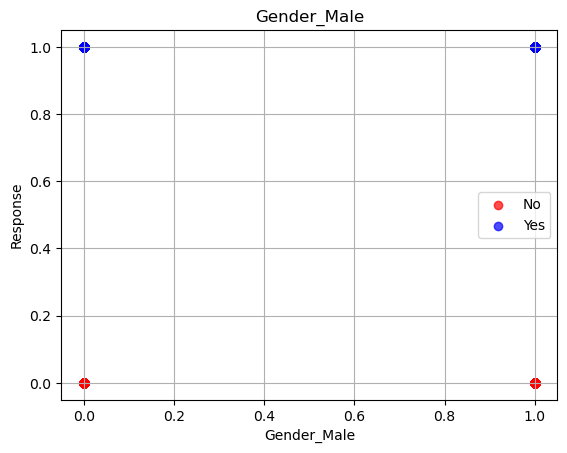

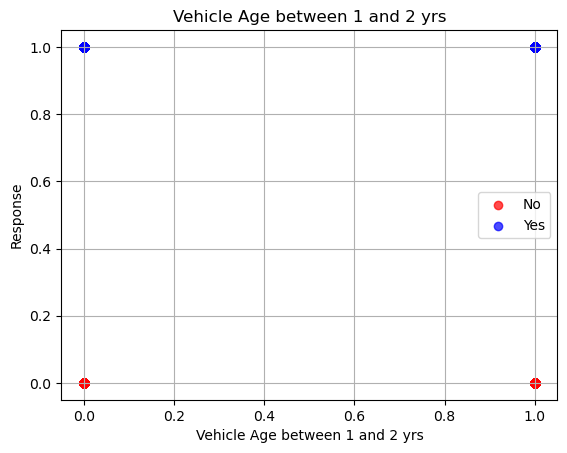

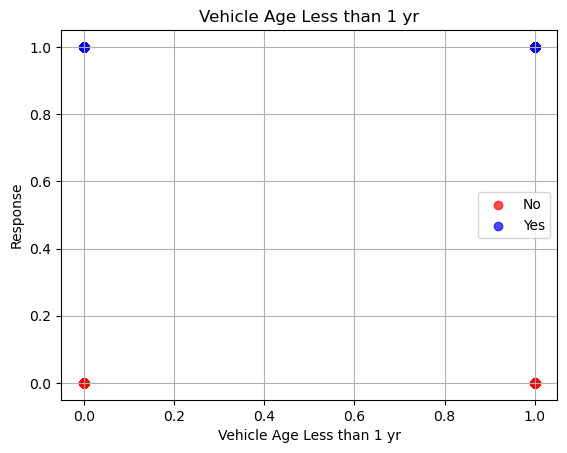

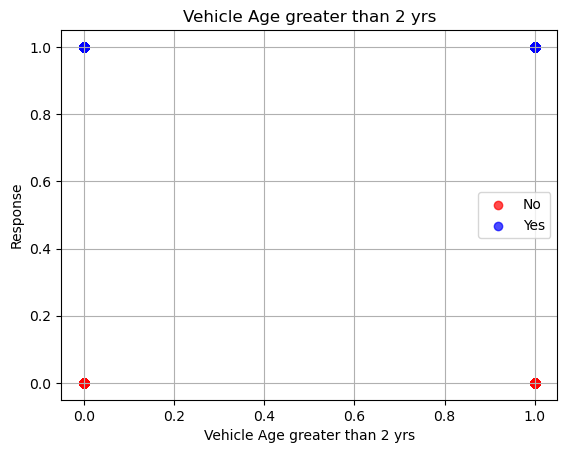

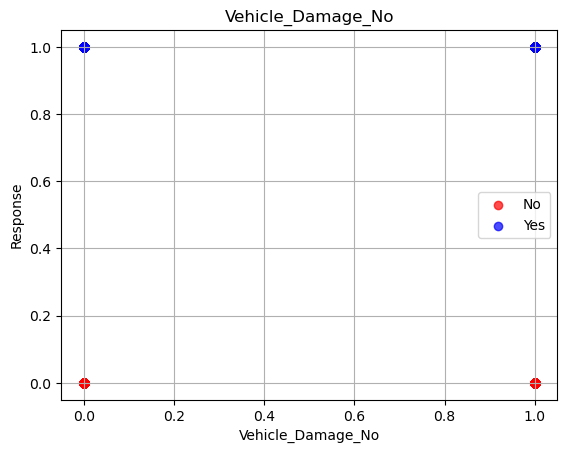

In [21]:
# Plotting scatter training data for relevancy 

def scatter():
    numerical_columns = train.select_dtypes(include=['int8', 'float32', 'uint8', 'int16']).columns
    for column in numerical_columns[:-1]:
        plt.figure()
        plt.scatter(train[train['Response'] == 0][column], train[train['Response'] == 0]['Response'], label='No', color='red', alpha=0.7)
        plt.scatter(train[train['Response'] == 1][column], train[train['Response'] == 1]['Response'], label='Yes', color='blue', alpha=0.7)
        plt.legend()
        plt.title(column)
        plt.ylabel('Response')
        plt.xlabel(column)
        plt.grid()
        plot_path = f"{_plots}{column}_scatter.jpg"
        plt.savefig(plot_path)
        plt.show()

scatter()

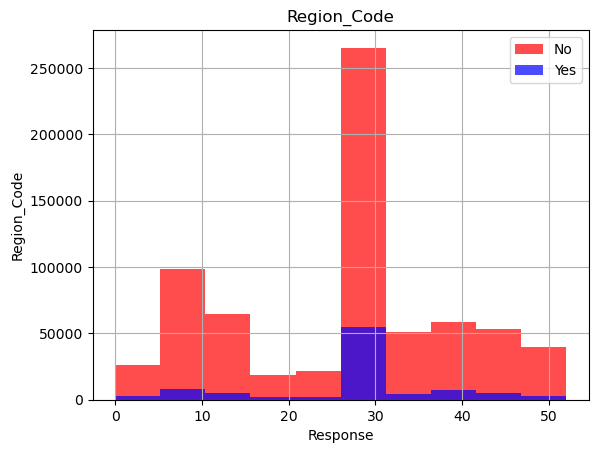

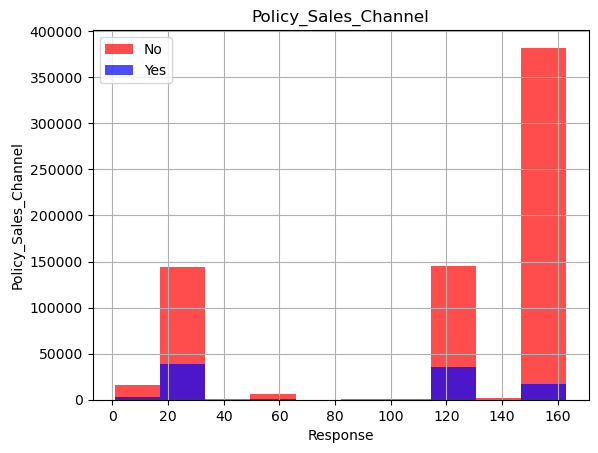

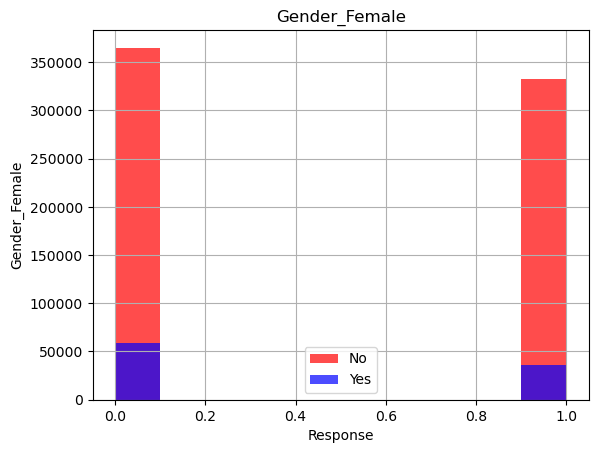

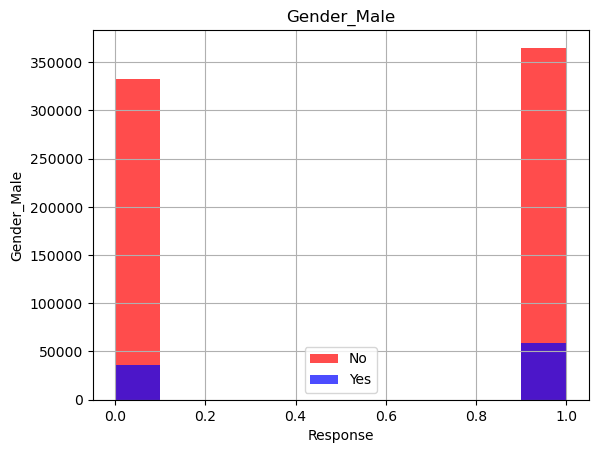

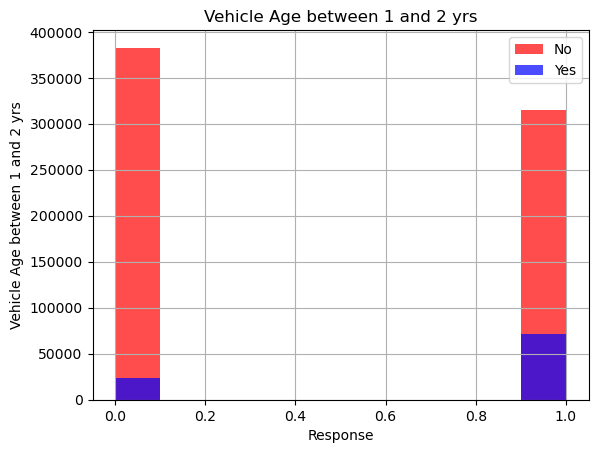

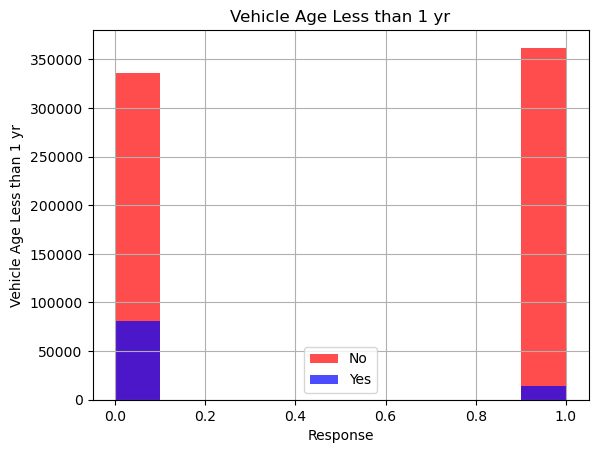

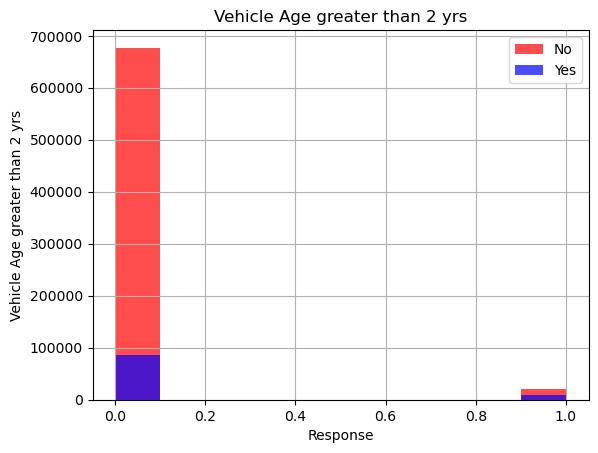

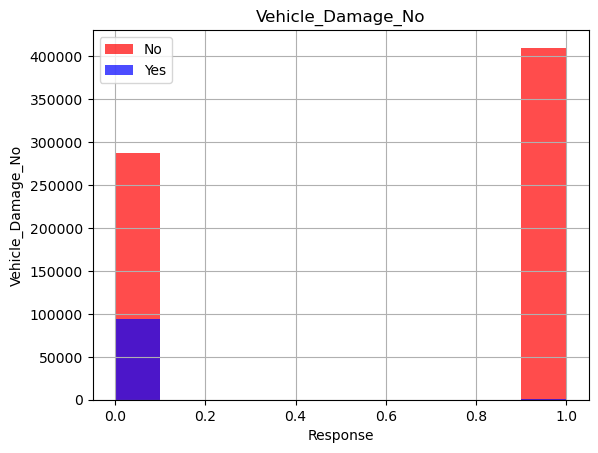

In [22]:
# Plotting histogram training data for relevancy 

def histogram():
    numerical_columns = train.select_dtypes(include=['int8', 'float32', 'uint8', 'int16']).columns
    for column in numerical_columns[:-1]:
        plt.figure()
        plt.hist(train[train['Response'] == 0][column], label='No', color='red', alpha=0.7, density=False)
        plt.hist(train[train['Response'] == 1][column], label='Yes', color='blue', alpha=0.7, density=False)
        plt.legend()
        plt.title(column)
        plt.ylabel(column)
        plt.xlabel('Response')
        plt.grid()
        plot_path = f"{_plots}{column}_histogram.jpg"
        plt.savefig(plot_path)  
        plt.show()

histogram()

# K-NearestNeighboor Model 

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93   1605454
           1       0.33      0.13      0.19    220051

    accuracy                           0.86   1825505
   macro avg       0.61      0.55      0.56   1825505
weighted avg       0.82      0.86      0.84   1825505



In [43]:
pkl.dump(knn_model, open('./tested/KNearestNeighboor.pkl', 'wb'))
print(accuracy_score(y_test, knn_pred))
del knn_model, knn_pred

0.8635221486657116


# Gaussian Naive Bayes Model 

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)
print(classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83   1605454
           1       0.29      0.85      0.44    220051

    accuracy                           0.74   1825505
   macro avg       0.63      0.79      0.63   1825505
weighted avg       0.89      0.74      0.78   1825505



In [41]:
pkl.dump(gnb_model, open('./tested/GaussianNaiveBaye.pkl', 'wb'))
print(accuracy_score(y_test, gnb_pred))
del gnb_model, gnb_pred

0.7358599401261569


# Logistic Regression Model

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93   1605454
           1       0.21      0.01      0.02    220051

    accuracy                           0.88   1825505
   macro avg       0.54      0.50      0.48   1825505
weighted avg       0.80      0.88      0.82   1825505



In [46]:
pkl.dump(log_model, open('./tested/LogisticRegression.pkl', 'wb'))
print(accuracy_score(y_test, log_pred))
del log_model, log_pred

0.8766166074593058


# Support Vector Classifier Model

In [27]:
from sklearn.svm import SVC

In [26]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)
print(classification_report(y_test, svc_pred))

In [ ]:
pkl.dump(svc_model, open('./tested/SupportVectorMachine.pkl', 'wb'))
print(accuracy_score(y_test, svc_pred))
del svc_model, svc_pred

# Decision Tree Cassifier Model

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)
dtc_pred = dtc_model.predict(X_test)
print(classification_report(y_test, dtc_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91   1605454
           1       0.33      0.35      0.34    220051

    accuracy                           0.84   1825505
   macro avg       0.62      0.63      0.62   1825505
weighted avg       0.84      0.84      0.84   1825505



In [49]:
pkl.dump(dtc_model, open('./tested/DecisionTreeCassifier.pkl', 'wb'))
print(accuracy_score(y_test, dtc_pred))
del dtc_model, dtc_pred

0.8370544041237904


# Random Forest Classifier Model

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
rfc_pred = rfc_model.predict(X_test)
print(classification_report(y_test, rfc_pred))

In [ ]:
pkl.dump(rfc_model, open('./tested/RandomForestClassifier.pkl', 'wb'))
print(accuracy_score(y_test, rfc_pred))
del rfc_model, rfc_pred

# Linear Discriminant Analysis Model

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [51]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
lda_pred = lda_model.predict(X_test)
print(classification_report(y_test, lda_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94   1605454
           1       0.39      0.02      0.03    220051

    accuracy                           0.88   1825505
   macro avg       0.64      0.51      0.48   1825505
weighted avg       0.82      0.88      0.83   1825505



In [52]:
pkl.dump(lda_model, open('./tested/LinearDiscriminantAnalysis.pkl', 'wb'))
print(accuracy_score(y_test, lda_pred))
del lda_model, lda_pred

0.8783268191541519


# Gradient Boosting Classifier Model

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

In [54]:
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train, y_train)
gbc_pred = gbc_model.predict(X_test)
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94   1605454
           1       0.63      0.00      0.00    220051

    accuracy                           0.88   1825505
   macro avg       0.76      0.50      0.47   1825505
weighted avg       0.85      0.88      0.82   1825505



In [55]:
pkl.dump(gbc_model, open('./tested/GradientBoostingClassifier.pkl', 'wb'))
print(accuracy_score(y_test, gbc_pred))
del gbc_model, gbc_pred

0.8795735974428993


# Neural Network Classifier Model

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
nnc_model = MLPClassifier()
nnc_model.fit(X_train, y_train)
nnc_pred = nnc_model.predict(X_test)
print(classification_report(y_test, nnc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89465
           1       1.00      1.00      1.00    118635

    accuracy                           1.00    208100
   macro avg       1.00      1.00      1.00    208100
weighted avg       1.00      1.00      1.00    208100



In [ ]:
pkl.dump(nnc_model, open('./tested/NeuralNetworkClassifier.pkl', 'wb'))
print(accuracy_score(y_test, nnc_pred))
del nnc_model, nnc_pred

# X Gradient Boost Classifier

In [16]:
from xgboost import XGBClassifier

In [17]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94   1605454
           1       0.57      0.09      0.15    220051

    accuracy                           0.88   1825505
   macro avg       0.73      0.54      0.54   1825505
weighted avg       0.85      0.88      0.84   1825505



In [64]:
pkl.dump(xgb_model, open('./tested/XGradientBoostClassifier.pkl', 'wb'))
print(accuracy_score(y_test, xgb_pred))
del xgb_model, xgb_pred

0.8821126208912055


# Cat Boosting Classifier

In [13]:
from catboost import CatBoostClassifier

In [70]:
cat_model = CatBoostClassifier()
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
print(classification_report(y_test, cat_pred))

839:	learn: 0.2418155	total: 15m 8s	remaining: 2m 52s
840:	learn: 0.2418125	total: 15m 9s	remaining: 2m 51s
841:	learn: 0.2418097	total: 15m 10s	remaining: 2m 50s
842:	learn: 0.2418073	total: 15m 11s	remaining: 2m 49s
843:	learn: 0.2418043	total: 15m 12s	remaining: 2m 48s
844:	learn: 0.2418007	total: 15m 13s	remaining: 2m 47s
845:	learn: 0.2417985	total: 15m 15s	remaining: 2m 46s
846:	learn: 0.2417959	total: 15m 16s	remaining: 2m 45s
847:	learn: 0.2417922	total: 15m 17s	remaining: 2m 44s
848:	learn: 0.2417894	total: 15m 18s	remaining: 2m 43s
849:	learn: 0.2417868	total: 15m 19s	remaining: 2m 42s
850:	learn: 0.2417839	total: 15m 20s	remaining: 2m 41s
851:	learn: 0.2417826	total: 15m 21s	remaining: 2m 40s
852:	learn: 0.2417803	total: 15m 23s	remaining: 2m 39s
853:	learn: 0.2417768	total: 15m 24s	remaining: 2m 37s
854:	learn: 0.2417746	total: 15m 25s	remaining: 2m 36s
855:	learn: 0.2417713	total: 15m 26s	remaining: 2m 35s
856:	learn: 0.2417690	total: 15m 27s	remaining: 2m 34s
857:	learn: 

In [73]:
pkl.dump(cat_model, open('./tested/CatBoostClassifier.pkl', 'wb'))
print(accuracy_score(y_test, cat_pred))
del cat_model, cat_pred

0.8836245312940803


# Ada Boosting Classifier 

In [12]:
from sklearn.ensemble import AdaBoostClassifier

In [13]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
ada_pred = ada_model.predict(X_test)
print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94   1605454
           1       0.44      0.00      0.01    220051

    accuracy                           0.88   1825505
   macro avg       0.66      0.50      0.47   1825505
weighted avg       0.83      0.88      0.82   1825505



In [14]:
pkl.dump(ada_model, open('./tested/AdaBoostClassifier.pkl', 'wb'))
print(accuracy_score(y_test, ada_pred))
del ada_model, ada_pred

0.8793648880720677


# Quadratic Discriminant Analysis

In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [16]:
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)
qda_pred = qda_model.predict(X_test)
print(classification_report(y_test, qda_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94   1605454
           1       0.00      0.00      0.00    220051

    accuracy                           0.88   1825505
   macro avg       0.44      0.50      0.47   1825505
weighted avg       0.77      0.88      0.82   1825505



In [17]:
pkl.dump(qda_model, open('./tested/QuadraticDiscriminantAnalysis.pkl', 'wb'))
print(accuracy_score(y_test, qda_pred))
del qda_model, qda_pred

0.8794574651945626


# Perceptron Classifier Model

In [18]:
from sklearn.linear_model import Perceptron

In [19]:
ptn_model = Perceptron()
ptn_model.fit(X_train, y_train)
ptn_pred = ptn_model.predict(X_test)
print(classification_report(y_test, ptn_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94   1605454
           1       0.33      0.00      0.00    220051

    accuracy                           0.88   1825505
   macro avg       0.61      0.50      0.47   1825505
weighted avg       0.81      0.88      0.82   1825505



In [20]:
pkl.dump(ptn_model, open('./tested/Perceptron.pkl', 'wb'))
print(accuracy_score(y_test, ptn_pred))
del ptn_model, ptn_pred

0.8794569174009383


# Ridge Classifier Model

In [21]:
from sklearn.linear_model import RidgeClassifier

In [24]:
rig_model = RidgeClassifier()
rig_model.fit(X_train, y_train)
rig_pred = rig_model.predict(X_test)
print(classification_report(y_test, rig_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94   1605454
           1       0.00      0.00      0.00    220051

    accuracy                           0.88   1825505
   macro avg       0.44      0.50      0.47   1825505
weighted avg       0.77      0.88      0.82   1825505



In [25]:
pkl.dump(rig_model, open('./tested/Perceptron.pkl', 'wb'))
print(accuracy_score(y_test, rig_pred))
del rig_model, rig_pred

0.8794574651945626


# Logistic Regression Cross Validation

In [26]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
lcv_model = LogisticRegressionCV()
lcv_model.fit(X_train, y_train)
lcv_pred = lcv_model.predict(X_test)
print(classification_report(y_test, lcv_pred))

In [ ]:
pkl.dump(lcv_model, open('./tested/LogisticRegressionCV.pkl', 'wb'))
print(accuracy_score(y_test, lcv_pred))
del lcv_model, lcv_pred

# Bagging Classifier Model

In [28]:
from sklearn.ensemble import BaggingClassifier

In [29]:
bgf_model = BaggingClassifier()
bgf_model.fit(X_train, y_train)
bgf_pred = bgf_model.predict(X_test)
print(classification_report(y_test, bgf_pred))

In [ ]:
pkl.dump(bgf_model, open('./tested/LogisticRegressionCV.pkl', 'wb'))
print(accuracy_score(y_test, bgf_pred))
del bgf_model, bgf_pred

# Check for best metrics

In [72]:
def Statistics():
    # print("1. KNeighborsClassifier Score: \t\t\t", accuracy_score(y_test, knn_pred))
    # print("2. Gaussian Naive Bayes Score: \t\t\t", accuracy_score(y_test, gnb_pred))
    # print("3. Logistic Regressor Score: \t\t\t", accuracy_score(y_test, log_pred))
    # print("4. Support Vector Classification Score: ", accuracy_score(y_test, svc_pred))
    # print("5. Decision Tree Score: \t\t\t", accuracy_score(y_test, dtc_pred))
    # print("6. Random Forest Score: \t\t\t", accuracy_score(y_test, rfc_pred))
    # print("7. Linear Discriminant Analysis Score: \t\t", accuracy_score(y_test, lda_pred))
    # print("8. Gradient Boost Classifier Score: \t\t", accuracy_score(y_test, gbc_pred))
    # print("9. Neural Network Score: \t\t\t", accuracy_score(y_test, nnc_pred))
    # print("10. X Gradient Boost Classifier Score: \t\t", accuracy_score(y_test, xgb_pred))
    # print("11. Cat Boost Classifier Score: \t\t\t", accuracy_score(y_test, cat_pred))

Statistics()

11. Cat Boost Classifier Score: 			 0.8836245312940803


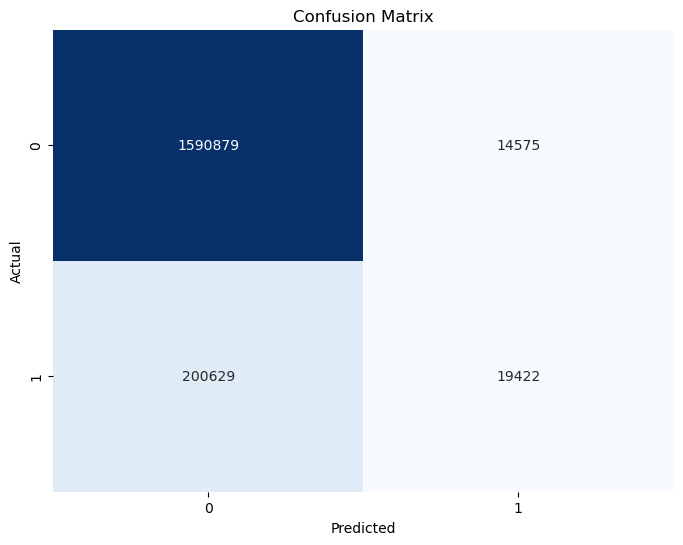

In [18]:
# Print confusion matrix for the best model:

confusion = confusion_matrix(y_test, cat_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Perform Grid Search Cross Validation

In [14]:
# Set functions to perform text file manipulation

def log_to_file(log_file, text):
    with open(log_file, 'a') as f:
        f.write(text + '\n')

def log_grid_search_results(cv_results, log_file):
    means = cv_results['mean_test_score']
    stds = cv_results['std_test_score']
    params = cv_results['params']
    for mean, std, param in zip(means, stds, params):
        log_to_file(log_file, f"Mean: {mean:.4f}, Std: {std:.4f}, Params: {param}")

In [15]:
# Set grid search cv parameters 

params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

In [16]:
# Reshape the target data
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [ ]:
# Start the searching for parameters

log_file = f'./model/model.log'
xgb_model = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring="accuracy", n_jobs=-1, cv=5, verbose=1)
grid_search.fit(X_train, y_train)
log_grid_search_results(grid_search.cv_results_, log_file)

In [52]:
# Print the best parameters:
grid_search.best_params_

{'n_neighbors': 3}

In [13]:
# Set best parameters for the new model

cat_params = {
    # 'lambda': 0.22277962201504303, 
    # 'alpha': 0.6100416446970967,
    # 'colsample_bytree': 0.7,
    # 'subsample': 0.7,
    # 'learning_rate': 0.018,
    # 'n_estimators': 944,
    # 'max_depth': 15,
    # 'random_state': 2020,
    # 'min_child_weight': 61


    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'learning_rate':0.05,
    'iterations':5000,
    'depth':9,
    'random_strength':0,
    'l2_leaf_reg':0.5,
    'task_type':'CPU',
    'random_seed':42,
    'verbose':False
}

In [ ]:
# Traing and validate the model

cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(X_train, y_train, 
    verbose=5, 
    eval_set=(X_test, y_test),
    use_best_model=True,
    plot=True)
cat_pred = cat_model.predict(X_test)
print(classification_report(y_test, cat_pred))

In [47]:
# Accuracy for the fitted model
print(f"Accuracy Score: {accuracy_score(y_test, xgb_pred)}")
print(f"Area Under the Curve (AUC): {roc_auc_score(y_test, xgb_pred)}")

Accuracy Score: 0.8829501973426531
Area Under the Curve (AUC): 0.554310629898519


In [ ]:
# Save the model 
pkl.dump(cat_model, open('./tested/FINAL_MODEL.pkl', 'wb'))

# Pipeline Model & Scaler

In [48]:
# Create the pipeline

model = xgb_model
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('model', model)
])

pipeline.fit(X_train, y_train)
y_pipe = pipeline.predict(X_test)
print(classification_report(y_test, y_pipe))
print("Final Score: ", accuracy_score(y_test, y_pipe))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94   1605454
           1       0.57      0.12      0.20    220051

    accuracy                           0.88   1825505
   macro avg       0.73      0.55      0.57   1825505
weighted avg       0.85      0.88      0.85   1825505

Final Score:  0.8828559768392855


In [61]:
# Load the info about model in the file

def update_info(full=True):
    info = open(_info, "w")
    pipeline.fit(X_train, y_train)
    y_pipe = pipeline.predict(X_test)
    model_info = [f"Accuracy Score: {accuracy_score(y_test, y_pipe)}\n", 
                  f"Model Name: {pipeline.named_steps['model']}\n", 
                  f"Time:   {dt.datetime.now()}\n\n",
                  f"Report: {classification_report(y_test, y_pipe)}"]
    info.writelines(model_info)
    print(''.join(model_info))
    if full:
        pipeline.fit(X_data, y_data)

In [62]:
# Load Model In File Project

val = input('Are you sure you want to save the last model: ')
if(val == 'y'):
    update_info(False)
    model = pipeline
    print('Saving . . .')
    pkl.dump(model, open(_model, 'wb'))

Accuracy Score: 0.882906921646339
Model Name: XGBClassifier(alpha=0.6100416446970967, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.22277962201504303,
              learning_rate=0.018, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=61, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=944,
              n_jobs=None, ...)
Time:   2024-07-22 04:50:04.937375

Report:               precision    recall  f1-score   support

           0       0.89      0.99      0.94   1605454
           1       0.57      0.12    

# Send Submission

In [61]:
test = import_data(_test, index_col = "id", engine="pyarrow")

test["Policy_Sales_Channel"] = test["Policy_Sales_Channel"].astype(np.int16)
test["Region_Code"] = test["Region_Code"].astype(np.int8)
index = int(pd.read_csv(_submission, nrows=1)['id'][0])
test = pd.get_dummies(test, columns=['Gender', 'Vehicle_Age', 'Vehicle_Damage'])

test.rename(columns={
    'Vehicle_Age_< 1 Year': 'Vehicle Age Less than 1 yr',
    'Vehicle_Age_1-2 Year': 'Vehicle Age between 1 and 2 yrs',
    'Vehicle_Age_> 2 Years': 'Vehicle Age greater than 2 yrs'
}, inplace=True)

cat_pred = cat_model.predict(test)
submission = pd.DataFrame({
    'id': range(index, index + len(test)),
    'Response': cat_pred
})
submission.to_csv(_submission, index=False)
submission.head()

Memory usage of dataframe is 643.68 MB
Memory usage after optimization is: 175.55 MB
Decreased by 72.7%


,id,Response
0,11504798,0
1,11504799,0
2,11504800,0
3,11504801,0
4,11504802,0


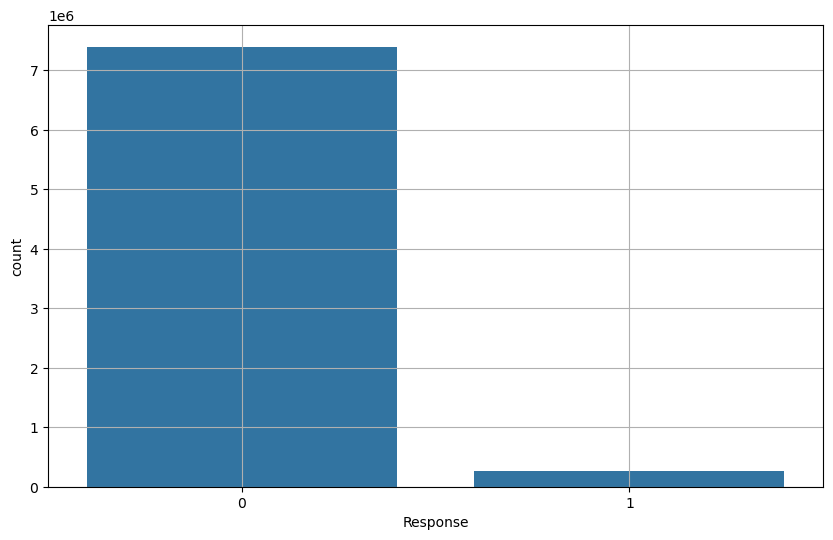

In [62]:
# Final plot of the distribution output

plt.figure(figsize=(10, 6))
sns.countplot(data=submission, x="Response")
plt.grid()
plt.show()

In [19]:
# Display all models

index = 1
for trainers in os.listdir(_tested):
    print(f"{index}. {trainers.replace('.pkl', '')}")
    index += 1


1. GaussianNaiveBaye
2. KNearestNeighboor
3. LogisticRegression
4. DecisionTreeCassifier
5. LinearDiscriminantAnalysis
6. GradientBoostingClassifier
7. XGradientBoostClassifier
8. CatBoostClassifier


In [22]:
# Load the best model 

try:
    id_model = int(input("Select a model id:"))
    final = all_models[id_model - 1]
    _path = f'{_tested}{final}'
    with open(_path, 'rb') as file:
        model = pkl.load(file)
    print(f'Model {final} loaded finished')
except:
    print("Error loading model . . .")

Model KNearestNeighboor.pkl loaded finished


In [12]:
# Try the trained model

with open('./model/model.pkl', 'rb') as file:
    cat_model = pkl.load(file)

In [13]:
cat_pred = cat_model.predict(X_test)
cat_pred = pd.DataFrame(cat_pred, columns=['Response'])
print('Zero predicted values \t\t', cat_pred[cat_pred['Response'] == 0].shape[0])
print('One predicted values \t\t', cat_pred[cat_pred['Response'] == 1].shape[0])

Zero predicted values 		 1773908
One predicted values 		 51597
